# Travail sur la ponctualité des trains

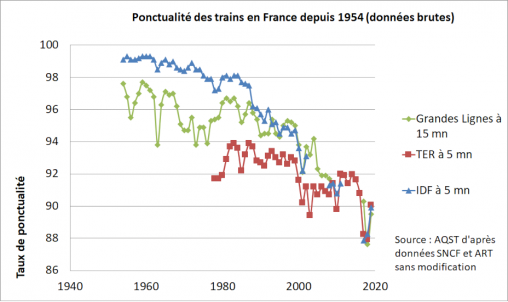

In [522]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np
import re
import matplotlib.pyplot as plt
import pprint

In [477]:
from sklearn import svm
import numpy as np
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [478]:
url_retards ='https://ressources.data.sncf.com/api/v2/catalog/datasets/regularite-mensuelle-tgv-aqst/exports/json?limit=-1&offset=0&timezone=UTC'
retards = requests.get(url_retards)
wb_retards = retards.json()

df_retards = pd.DataFrame(wb_retards)
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,None,213,8.479969,...,32,5.363539,9,4,20.000000,35.000000,16.666667,16.666667,8.333333,3.333333
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,None,193,7.294991,...,56,7.225734,29,11,37.333333,26.666667,21.333333,4.000000,9.333333,1.333333


In [479]:
df_retards['nb_retards'] = df_retards['nb_train_retard_sup_15']+df_retards['nb_train_retard_sup_30']+df_retards['nb_train_retard_sup_60']


In [480]:
df_retards['prct_nb_train_depart_retard'] = df_retards['nb_train_depart_retard']/df_retards['nb_train_prevu']*100
df_retards['prct_nb_annulation'] = df_retards['nb_annulation']/df_retards['nb_train_prevu']*100
df_retards[['annee','mois']]=df_retards.date.str.split('-',expand=True)
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,nb_retards,prct_nb_train_depart_retard,prct_nb_annulation,annee,mois
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,None,213,8.479969,...,35.000000,16.666667,16.666667,8.333333,3.333333,45,52.463054,0.246305,2018,01
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,None,193,7.294991,...,26.666667,21.333333,4.000000,9.333333,1.333333,96,36.761905,0.571429,2018,01


In [481]:
df_retards = df_retards.drop('commentaire_annulation', axis = 1)
df_retards = df_retards.drop('commentaire_retards_depart', axis = 1)
df_retards = df_retards.drop('commentaires_retard_arrivee', axis = 1)
df_retards['annee'] = pd.to_numeric(df_retards['annee'])
df_retards['mois'] = pd.to_numeric(df_retards['mois'])

(array([   6.,   11.,   75.,  500., 1471., 2769., 1769.,  188.,   24.,
          16.]),
 array([-2.30258509, -1.49669286, -0.69080062,  0.11509162,  0.92098385,
         1.72687609,  2.53276833,  3.33866056,  4.1445528 ,  4.95044504,
         5.75633727]),
 <BarContainer object of 10 artists>)

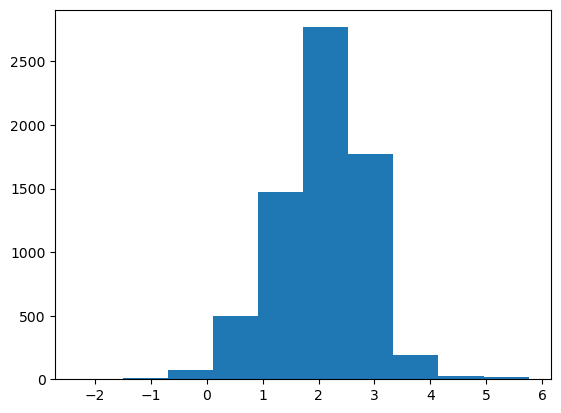

In [482]:
df_retards.dropna(inplace = True)
df_retards = df_retards.drop(df_retards[df_retards['retard_moyen_depart']==0].index)
df_retards['log_retard_moyen_depart'] = np.log(df_retards['retard_moyen_depart'])
plt.hist(df_retards['log_retard_moyen_depart'])


In [483]:
df_retards_initial = df_retards
df_retards_initial

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,nb_retards,prct_nb_train_depart_retard,prct_nb_annulation,annee,mois,log_retard_moyen_depart
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,213,8.479969,4.567119,...,16.666667,16.666667,8.333333,3.333333,45,52.463054,0.246305,2018,1,2.137707
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,193,7.294991,2.720211,...,21.333333,4.000000,9.333333,1.333333,96,36.761905,0.571429,2018,1,1.987188
2,2018-01,National,PARIS MONTPARNASSE,ANGERS SAINT LAUD,90,385,3,49,8.362585,0.730105,...,21.428571,23.809524,9.523810,0.000000,31,12.727273,0.779221,2018,1,2.123768
3,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,37,9.501351,1.003981,...,15.384615,19.230769,0.000000,0.000000,50,14.919355,0.403226,2018,1,2.251434
4,2018-01,National,POITIERS,PARIS MONTPARNASSE,94,472,4,224,6.784673,3.229701,...,19.298246,15.789474,1.754386,1.754386,52,47.457627,0.847458,2018,1,1.914666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6932,2022-08,National,PARIS MONTPARNASSE,NANTES,130,584,5,68,15.297059,1.453080,...,15.909091,22.727273,2.272727,15.909091,75,11.643836,0.856164,2022,8,2.727661
6933,2022-08,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,62,509,0,53,10.325786,0.677472,...,26.530612,42.857143,6.122449,12.244898,35,10.412574,0.000000,2022,8,2.334644
6934,2022-08,National,PARIS MONTPARNASSE,TOURS,74,167,0,16,12.529167,0.835529,...,16.666667,50.000000,8.333333,16.666667,12,9.580838,0.000000,2022,8,2.528059
6935,2022-08,National,SAINT ETIENNE CHATEAUCREUX,PARIS LYON,169,119,0,34,4.072549,1.626754,...,28.571429,23.809524,0.000000,9.523810,14,28.571429,0.000000,2022,8,1.404269


In [484]:
df_retards = df_retards.groupby(['date'])[['duree_moyenne','log_retard_moyen_depart','prct_cause_materiel_roulant', 'prct_cause_infra','prct_cause_gestion_trafic','nb_train_prevu', 'prct_cause_externe','prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs', 'nb_retards']].sum()
df_retards.head()


,duree_moyenne,log_retard_moyen_depart,prct_cause_materiel_roulant,prct_cause_infra,prct_cause_gestion_trafic,nb_train_prevu,prct_cause_externe,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,nb_retards
date,,,,,,,,,,
2018-01,22137,271.575599,2478.679317,3786.861079,2340.888356,35229,3383.855911,551.631691,358.083645,5679
2018-02,22527,304.815586,2445.393907,2530.044261,2243.836871,32419,5235.303272,422.500272,122.921417,8167
2018-03,22571,273.610808,2751.999829,2478.596045,2541.962919,35458,4105.418780,643.707817,278.314610,5442
2018-04,22016,279.743754,2958.740950,2805.491754,2241.162929,36218,3340.405710,959.695640,394.503017,3991
2018-05,19996,368.968815,2387.350354,1995.982465,1647.073663,35977,3805.545060,716.798272,547.250187,5221


In [485]:
x = df_retards[['prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']]
y = df_retards[['duree_moyenne']].values.ravel()

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, train_size=0.8)
xTest

,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
date,,
2020-05,494.150878,220.997816
2018-01,551.631691,358.083645
2022-06,1149.108105,942.553014
2021-01,804.106329,967.809402
2019-03,469.816177,331.439823
2021-12,906.202147,2080.707639
2019-04,874.014173,305.120953
2018-07,535.090078,545.412849
2021-08,1164.274726,2556.717910


In [486]:
#on fait la regression lineaire
reg = LinearRegression()
reg.fit(xTrain, yTrain) #estime les coeffs
reg.coef_
reg.intercept_

19141.423887650148

In [487]:
"""
clf = svm.SVC(kernel = 'rbf', C=1) #crée une classe C=1 (parametre d'hyperregularisation C=1 par défaut)
clf = make_pipeline(StandardScaler(), SVC(kernel = 'linear', C=1))
clf.fit(xTrain, yTrain)
yPred = clf.predict(xTrain)
"""

"\nclf = svm.SVC(kernel = 'rbf', C=1) #crée une classe C=1 (parametre d'hyperregularisation C=1 par défaut)\nclf = make_pipeline(StandardScaler(), SVC(kernel = 'linear', C=1))\nclf.fit(xTrain, yTrain)\nyPred = clf.predict(xTrain)\n"

In [488]:
#puis on predit les resultats
yPred = reg.predict(xTrain)
yPred

array([20301.32479717, 19930.31644633, 20182.4747438 , 19299.93237938,
       20687.72611293, 21528.87213754, 20655.23231523, 21726.17876717,
       20955.04310619, 21099.78359473, 20755.79028958, 21031.10554577,
       20577.7077215 , 21158.37142857, 19559.1249003 , 20615.11926094,
       20890.17762747, 20813.60572325, 20473.86615504, 20925.00187809,
       18610.72101552, 21598.73591913, 20813.65144204, 20354.08991895,
       21226.75332012, 18772.85791179, 20392.38919466, 21493.07578517,
       20196.8494557 , 21549.16404659, 21398.10401678, 20812.18839524,
       20600.53347174, 21655.78187113, 20980.99805737, 20520.32662404,
       21068.53323213, 20793.35201136, 21530.44165236, 21163.44598709,
       20609.78469143, 20921.46969297, 21388.09474021, 19571.90261552])

In [489]:
#on regarde si le score est satisfaisant
reg.score(xTrain, yTrain)

0.15715777110493967

In [490]:
epsilon = yTrain - yPred

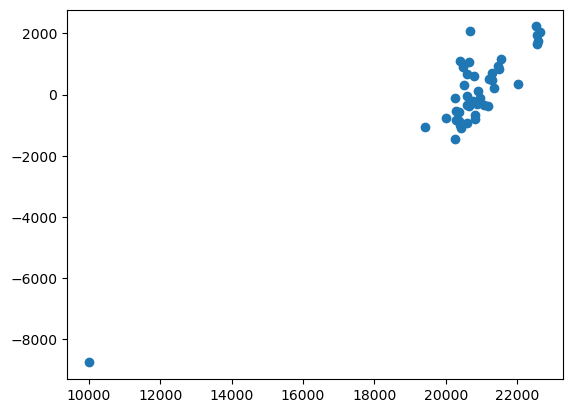

In [491]:
plt.scatter(yTrain, epsilon)

<font color='blue'> **On ajoute maintenant des variables explicatives** </font>

In [502]:
x = df_retards[['prct_cause_materiel_roulant', 'prct_cause_infra','prct_cause_gestion_trafic','nb_train_prevu', 'prct_cause_externe','prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']]
y = df_retards[['duree_moyenne']].values.ravel()

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, train_size=0.8)
xTest

,prct_cause_materiel_roulant,prct_cause_infra,prct_cause_gestion_trafic,nb_train_prevu,prct_cause_externe,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
date,,,,,,,
2021-07,2107.198961,2007.866487,1580.389599,34793,2732.707911,1343.866481,1927.970560
2022-07,2636.900224,1924.012060,2813.520400,38419,1857.449423,1319.696808,1548.421085
2018-07,2455.736254,2966.548870,2654.920974,35638,2242.290975,535.090078,545.412849
2018-01,2478.679317,3786.861079,2340.888356,35229,3383.855911,551.631691,358.083645
2020-07,1946.013115,2801.952820,2484.314835,30361,3812.617273,814.125718,440.976239
2018-08,3337.366692,2264.684435,2591.667157,33826,1838.160280,726.705938,641.415499
2022-01,2653.845038,2439.955820,1724.219769,35392,2684.177350,742.130564,1755.671460
2020-04,193.803419,3958.448573,300.000000,3325,367.249808,210.972222,969.525978
2020-11,1611.479621,4040.925378,1715.685738,9755,3017.139977,641.869422,272.899865


In [503]:
#on fait la regression lineaire
reg = LinearRegression()
reg.fit(xTrain, yTrain) #estime les coeffs
coef_duree_retards = reg.coef_
#reg.intercept_

In [504]:
#puis on predit les resultats
yPred = reg.predict(xTrain)
epsilon = yTrain - yPred
#on regarde si le score est satisfaisant
reg.score(xTrain, yTrain)

0.808516171351616

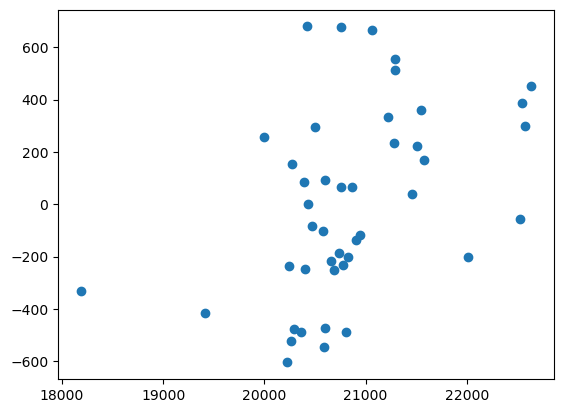

In [505]:
plt.scatter(yTrain, epsilon)

In [528]:
x = df_retards[['prct_cause_materiel_roulant', 'prct_cause_infra','prct_cause_gestion_trafic','nb_train_prevu', 'prct_cause_externe','prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']]
y = df_retards[['nb_retards']].values.ravel()

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, train_size=0.8)
xTest

,prct_cause_materiel_roulant,prct_cause_infra,prct_cause_gestion_trafic,nb_train_prevu,prct_cause_externe,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
date,,,,,,,
2019-04,2628.787949,2865.023968,3148.022920,32063,2279.030037,874.014173,305.120953
2021-08,2251.334251,1732.522013,1715.503267,34949,2279.647833,1164.274726,2556.717910
2021-09,1693.718039,2216.445857,1636.885080,32913,2432.209549,1401.813405,2218.928070
2020-01,2382.636523,3184.748355,2886.024181,26940,2657.967960,910.108125,278.514857
2022-01,2653.845038,2439.955820,1724.219769,35392,2684.177350,742.130564,1755.671460
2020-04,193.803419,3958.448573,300.000000,3325,367.249808,210.972222,969.525978
2022-04,2217.713333,2034.248562,2233.278608,36447,3146.451577,929.372984,1338.934936
2020-06,2076.838076,3936.604938,1435.175105,21908,2662.439468,886.928618,302.013796
2021-04,2059.965914,2098.047422,989.023270,31302,3695.365848,926.768820,1430.828726


In [529]:
#on fait la regression lineaire
reg = LinearRegression()
reg.fit(xTrain, yTrain) #estime les coeffs
coef_nb_retards = reg.coef_
#reg.intercept_

In [530]:
#puis on predit les resultats
yPred = reg.predict(xTrain)
epsilon = yTrain - yPred
#on regarde si le score est satisfaisant
reg.score(xTrain, yTrain)

0.4837898829153695

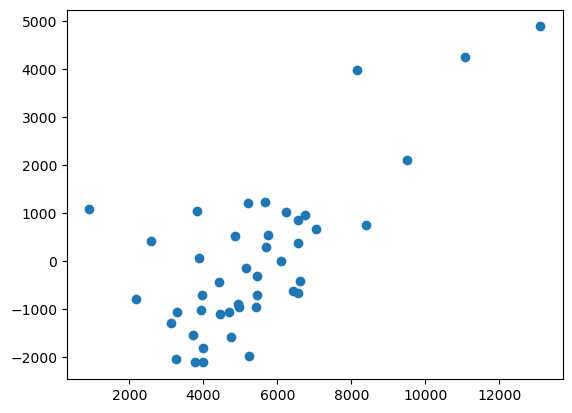

In [531]:
plt.scatter(yTrain, epsilon)

In [532]:
causes_retards = ['prct_cause_materiel_roulant', 'prct_cause_infra','prct_cause_gestion_trafic','nb_train_prevu', 'prct_cause_externe','prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']

In [533]:
dico_duree_retards = dict(zip(causes_retards, coef_duree_retards))
dico_nb_retards = dict(zip(causes_retards, coef_nb_retards))
pprint.pprint(dico_duree_retards)
print()
pprint.pprint(dico_nb_retards)


{'nb_train_prevu': 0.027645003520915035,
 'prct_cause_externe': 1.5884259668179006,
 'prct_cause_gestion_gare': 1.4041766149398773,
 'prct_cause_gestion_trafic': 1.2817961062396814,
 'prct_cause_infra': 1.638090612430986,
 'prct_cause_materiel_roulant': 1.787477927948914,
 'prct_cause_prise_en_charge_voyageurs': 1.543706372920416}

{'nb_train_prevu': 0.2489668341171949,
 'prct_cause_externe': -1.1103712616972328,
 'prct_cause_gestion_gare': 0.6460479890059307,
 'prct_cause_gestion_trafic': -0.22643464553832643,
 'prct_cause_infra': -1.680132606631107,
 'prct_cause_materiel_roulant': -1.061622012567804,
 'prct_cause_prise_en_charge_voyageurs': -1.733859961291452}


- les nombres de retards sont moins bien prédits que les durées de retard par le modèle 
- les problèmes de materiel roulant sont ce qui causent les retards les plus importants (en durée)
- à priori, les problèmes de gestion de gare sont ce qui causent le plus de retards 


**a faire : reprendre ce travail de regression en suivant les etapes des exercices 3 et 4 de la partie 3 du cours**